# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [3]:
# !ls -l assets 
# %pip install --user torch torchvision

In [4]:
!curl -O https://raw.githubusercontent.com/udacity/workspaces-student-support/master/jupyter/workspace_utils.py

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1554  100  1554    0     0   8992      0 --:--:-- --:--:-- --:--:-- 11862


In [5]:
# Imports here
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from workspace_utils import active_session
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from collections import OrderedDict
from datetime import datetime
import os, copy, PIL, numpy as np, time
from torch.autograd import Variable
import torch.nn.functional as nnf
import pandas as pd
from sklearn.metrics import accuracy_score

## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [6]:
[d for d in dir(transforms) if 'rando' in d.lower()]

['RandomAffine',
 'RandomApply',
 'RandomChoice',
 'RandomCrop',
 'RandomGrayscale',
 'RandomHorizontalFlip',
 'RandomOrder',
 'RandomResizedCrop',
 'RandomRotation',
 'RandomSizedCrop',
 'RandomVerticalFlip']

In [7]:
data_dir = 'flowers'
data_transforms = {'train': transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], 
                                                            [0.229, 0.224, 0.225])
                                      ]),
                   'test': transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                            [0.229, 0.224, 0.225])
                                      ]),
                   'valid': transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                            [0.229, 0.224, 0.225])
                                      ])
                  }

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), 
                                          data_transforms[x]) 
                  for x in ['train', 'test','valid']}
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], 
                                                   batch_size=8, shuffle=True, 
                                                   num_workers=4) for x in ['train', 'valid', 'test']}

In [8]:
image_datasets['train'][0][0].shape

torch.Size([3, 224, 224])

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [9]:
import json
cat_to_name = json.load(open('cat_to_name.json', 'r'))
list(cat_to_name.items())[:5]

[('21', 'fire lily'),
 ('3', 'canterbury bells'),
 ('45', 'bolero deep blue'),
 ('1', 'pink primrose'),
 ('34', 'mexican aster')]

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. If you want to talk through it with someone, chat with your fellow students! You can also ask questions on the forums or join the instructors in office hours.

Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

torch.Size([8, 3, 224, 224])
torch.Size([8])


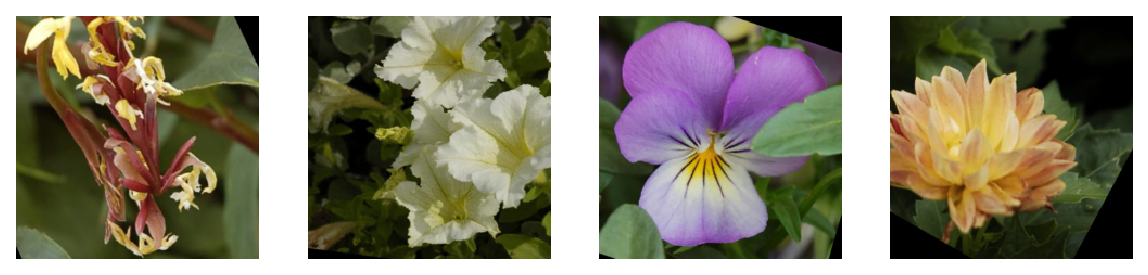

In [8]:
images, labels = next(iter(dataloaders_dict['train']))
# Flatten images
# images = images.view(images.shape[0], -1)

print(images.shape)
print(labels.shape)

def imshow(image, ax=None, title=None, normalize=True):
    """TAKEN FROM LESSON 4"""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

fig, axes = plt.subplots(figsize=(10,4), ncols=4)
for ii in range(4):
    ax = axes[ii]
    imshow(images[ii], ax=ax, normalize=True)

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [10]:
# Adapted From: https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

def initialize_model(num_classes, feature_extract, use_pretrained=True):
    model_ft = None
    input_size = 0
#         model_ft = models.vgg11_bn(pretrained=use_pretrained)
    model_ft = models.vgg16_bn(pretrained=use_pretrained)
    set_parameter_requires_grad(model_ft, feature_extract)
    num_ftrs = model_ft.classifier[6].in_features
    model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
    input_size = 224

    return model_ft, input_size

model, input_size = initialize_model(num_classes=102, #TODO -- Double Check?
                                     feature_extract=True)
model.to(device)
print(model)


Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.torch/models/vgg16_bn-6c64b313.pth
100%|██████████| 553507836/553507836 [00:33<00:00, 16672184.59it/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3)

In [11]:
%%time
# Adapted From: https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'valid':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history


CPU times: user 0 ns, sys: 6 µs, total: 6 µs
Wall time: 9.78 µs


In [12]:
%%time
# Adapted From: https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html
 
with active_session():
    feature_extract = True
    params_to_update = model.parameters()
    print("Params to learn:")
    if feature_extract:
        params_to_update = []
        for name,param in model.named_parameters():
            if param.requires_grad == True:
                params_to_update.append(param)
                print("\t",name)
    else:
        for name,param in model.named_parameters():
            if param.requires_grad == True:
                print("\t",name)

    optimizer_ft = optim.SGD(params_to_update, lr=0.01, momentum=0.9)            
    criterion = nn.CrossEntropyLoss()
    model, hist = train_model(model, dataloaders_dict, 
                              criterion, optimizer_ft) 

    # Uncomment this to save the model during an unattended run
    torch.save(model.state_dict(), 'checkpoint.pth')


Params to learn:
	 classifier.6.weight
	 classifier.6.bias
Epoch 0/24
----------
train Loss: 2.5748 Acc: 0.4573
valid Loss: 0.8371 Acc: 0.8020

Epoch 1/24
----------
train Loss: 2.1809 Acc: 0.5795
valid Loss: 0.8005 Acc: 0.8203

Epoch 2/24
----------
train Loss: 2.1767 Acc: 0.6194
valid Loss: 0.7478 Acc: 0.8496

Epoch 3/24
----------
train Loss: 2.2586 Acc: 0.6284
valid Loss: 0.8508 Acc: 0.8301

Epoch 4/24
----------
train Loss: 2.1587 Acc: 0.6540
valid Loss: 0.8287 Acc: 0.8447

Epoch 5/24
----------
train Loss: 2.2491 Acc: 0.6645
valid Loss: 0.7221 Acc: 0.8692

Epoch 7/24
----------
train Loss: 2.2875 Acc: 0.6653
valid Loss: 0.6018 Acc: 0.8949

Epoch 8/24
----------
train Loss: 2.3109 Acc: 0.6795
valid Loss: 0.8904 Acc: 0.8631

Epoch 9/24
----------
train Loss: 2.2980 Acc: 0.6827
valid Loss: 0.9145 Acc: 0.8496

Epoch 10/24
----------
train Loss: 2.4068 Acc: 0.6758
valid Loss: 0.7492 Acc: 0.8790

Epoch 11/24
----------
train Loss: 2.2376 Acc: 0.6947
valid Loss: 0.8242 Acc: 0.8802

Epoc

## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [25]:
%%time
# model.eval()

def evaluate_model(test_dl, model):
    """ADAPTED FROM:
    https://machinelearningmastery.com/pytorch-tutorial-develop-deep-learning-models/
    """
    with torch.no_grad():
        predictions, actuals = list(), list()
        for i, (inputs, targets) in enumerate(test_dl):
            inputs, targets = inputs.to(device), targets.to(device)
            # evaluate the model on the test set
            model.to(device)
            yhat = model(inputs)
            actual = targets
            # retrieve numpy array
#             yhat = yhat.cpu().detach().numpy()
#             actual = targets.cpu().numpy()
            # convert to class labels
#             yhat = np.argmax(yhat, axis=1)
            yhat = torch.argmax(yhat, dim=1)
            # reshape for stacking
            actual = actual.reshape((len(actual), 1))
            yhat = yhat.reshape((len(yhat), 1))
            # store
            predictions.append(yhat)
            actuals.append(actual)        
        predictions, actuals = np.vstack(predictions), np.vstack(actuals)
        # calculate accuracy
        acc = accuracy_score(actuals, predictions)
        return acc
    
acc = evaluate_model(dataloaders_dict['test'], model)
sep = '*'*40
print(f'{sep}\nAccuracy: {acc:.3f}\n{sep}')

****************************************
Accuracy: 0.885
****************************************


## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [26]:
"""
NOTE: I chose the simplest method and saved the entire model
as demonstrated on 
https://pytorch.org/tutorials/beginner/saving_loading_models.html
"""
torch.save(model.state_dict(), 'checkpoint.pth')

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [10]:
%%time
from pprint import pprint

# Adapted From: https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False


def initialize_model(num_classes, feature_extract, use_pretrained=True):
    model_ft = None
    input_size = 0
#         model_ft = models.vgg11_bn(pretrained=use_pretrained)
    model_ft = models.vgg16_bn(pretrained=use_pretrained)
    set_parameter_requires_grad(model_ft, feature_extract)
    num_ftrs = model_ft.classifier[6].in_features
    model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
    input_size = 224

    return model_ft, input_size


def load_model(checkpoint_path='checkpoint.pth'):
    state_dict = torch.load(checkpoint_path)
#     for i in state_dict.keys():
#         print(i)
    model, input_size = initialize_model(num_classes=102, feature_extract=True)
    model.load_state_dict(state_dict)
    return model

model = load_model()
model.eval()
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3)

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [11]:
def process_image(image_path):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    return transforms.Compose([transforms.Resize(255),
                               transforms.CenterCrop(224),
                               transforms.ToTensor(),
                               transforms.Normalize([0.485, 0.456, 0.406], 
                                                    [0.229, 0.224, 0.225])
                               ])(PIL.Image.open(image_path))


To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [12]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)    
    
    ax.imshow(image)
    return ax


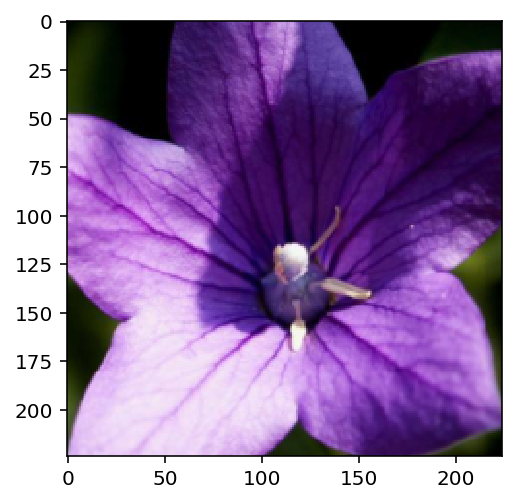

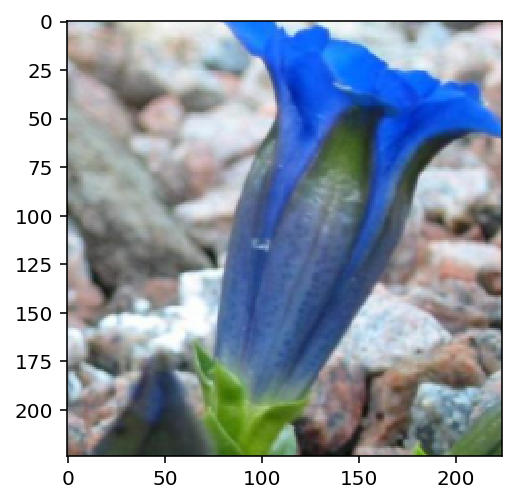

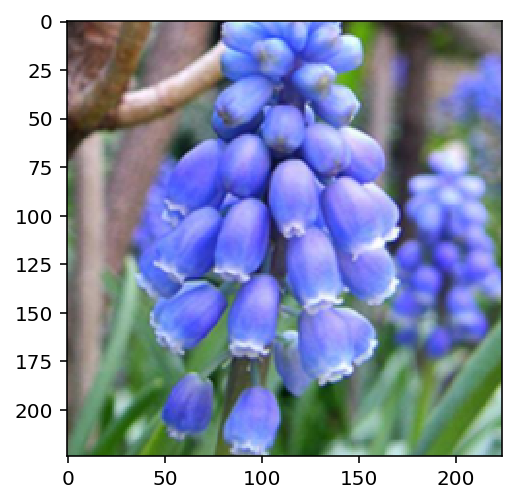

In [13]:
imshow(process_image('flowers/test/19/image_06175.jpg'))
imshow(process_image('flowers/test/28/image_05277.jpg'))
imshow(process_image('flowers/test/25/image_06593.jpg'))

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [44]:
def predict(image_path, model, topk=5):
    # Transform
    actual_category = cat_to_name[image_path.split('/')[2]]
    inputs = process_image(image_path).unsqueeze(0)
    model.eval()
    model, inputs = model.to(device), inputs.to(device)
    prob = nnf.softmax(model(inputs), dim=1)
    class_to_idx = image_datasets['train'].class_to_idx
    idx_to_class = {val: key for key, val in class_to_idx.items()}
    top_p, top_class = prob.topk(5, dim = 1)
    top_class = [idx_to_class[int(idx)] for idx in top_class[0]]
    top_p = [p.cpu().detach().numpy() for p in top_p[0]]
    class_name = [cat_to_name[t] for t in top_class]
    print('\n','*'*30, f'\nACTUAL FLOWER NAME: {actual_category}\n', '*'*30)
    df = pd.DataFrame({'probability': top_p, 
                     'category': top_class,
                        'class_name': class_name})
    df['probability'] = df['probability'].astype(float).round(5)
    return df
#     return pd.DataFrame({'probability': top_p.cpu().detach().numpy()[0], 
#                      'category': top_class.cpu().detach().numpy()[0]})


predict('flowers/test/19/image_06175.jpg', model)



 ****************************** 
ACTUAL FLOWER NAME: balloon flower
 ******************************


,probability,category,class_name
0,0.99999,19,balloon flower
1,0.00001,82,clematis
2,0.00000,51,petunia
3,0.00000,52,wild pansy
4,0.00000,95,bougainvillea


## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.


 ****************************** 
ACTUAL FLOWER NAME: balloon flower
 ******************************


,probability,category,class_name
0,0.99999,19,balloon flower
1,0.00001,82,clematis
2,0.00000,51,petunia
3,0.00000,52,wild pansy
4,0.00000,95,bougainvillea


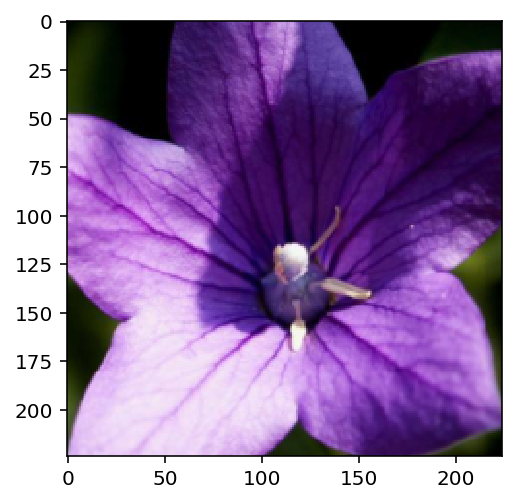

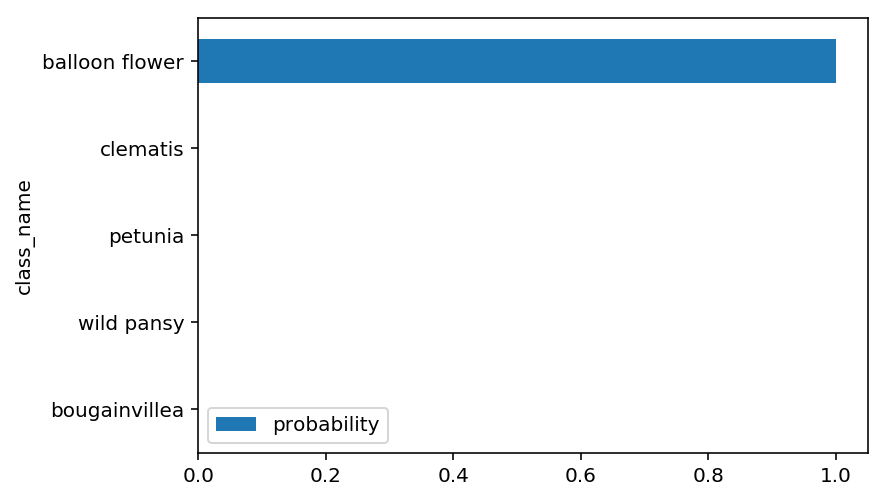

In [46]:
def predict_and_plot(model, img_path, cat_to_name):
    imshow(process_image(img_path))
    pred = predict(img_path, model)
    display(pred)
    pred = pred.sort_values(by='probability', ascending=False)[
        ['category','probability','class_name']
    ]
    pred['category'] = pred['category'].astype(int)
    ax = (pred[['class_name', 'probability']].sort_values(by='probability', ascending=False)
          .plot.barh(x='class_name',y='probability'))
    ax.invert_yaxis()

predict_and_plot(model, 'flowers/test/19/image_06175.jpg', cat_to_name)
# predict_and_plot(model, 'flowers/test/28/image_05277.jpg', cat_to_name)
# predict_and_plot(model, 'flowers/test/25/image_06593.jpg', cat_to_name)


 ****************************** 
ACTUAL FLOWER NAME: stemless gentian
 ******************************


,probability,category,class_name
0,1.0,28,stemless gentian
1,0.0,45,bolero deep blue
2,0.0,67,spring crocus
3,0.0,9,monkshood
4,0.0,3,canterbury bells


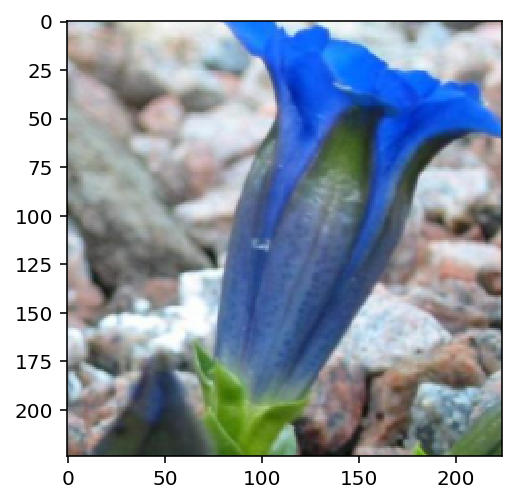

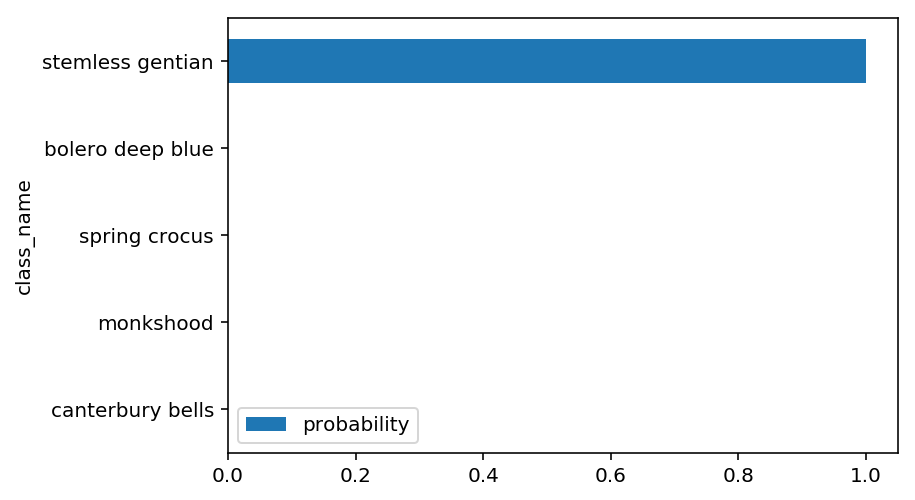

In [47]:
predict_and_plot(model, 'flowers/test/28/image_05277.jpg', cat_to_name)


 ****************************** 
ACTUAL FLOWER NAME: grape hyacinth
 ******************************


,probability,category,class_name
0,1.0,25,grape hyacinth
1,0.0,28,stemless gentian
2,0.0,67,spring crocus
3,0.0,76,morning glory
4,0.0,3,canterbury bells


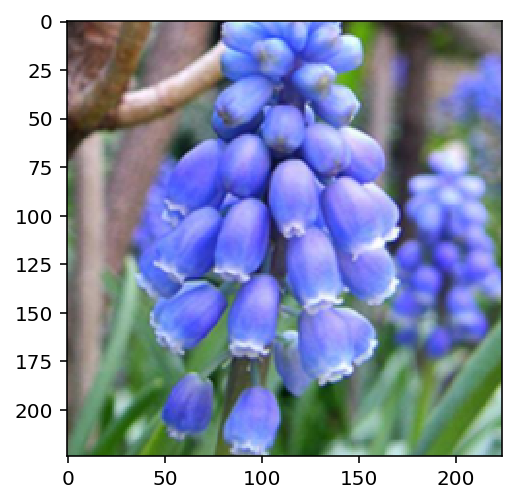

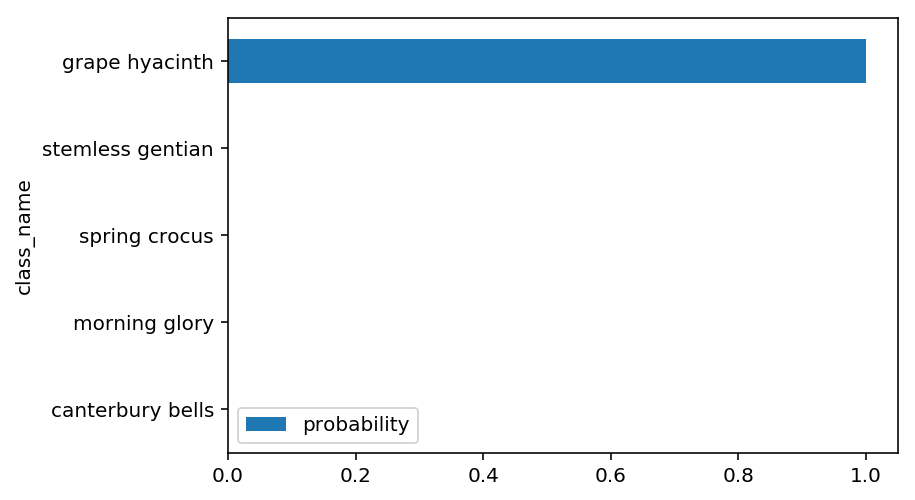

In [48]:
predict_and_plot(model, 'flowers/test/25/image_06593.jpg', cat_to_name)